# Mapping Police Violence

## Reading Point data

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


%matplotlib notebook

PID_Table = pd.read_csv('https://raw.githubusercontent.com/Police-Involved-Deaths-CA/Data/main/Spatial_Data/Geocoded_Points_not_Complete/PID_locations.csv')
PID_Table

,date,INDEX,id_victim,first_name,last_name,middle_name,age,gender,race,prov,...,Temp_Date,summary,ds_rank,Type,latitude,longitude,geocoding_attempt,geocoding_return,geocoding_notes,geocode_city
0,2000-01-30,238,0413_V1,Stuart,Mitchell,NaN,49.0,Male,Not Specified,ON,...,2000.001,NaN,NaN,Police Killing,43.658858,-79.365514,Winchester & Parliament Toronto ON,"Parliament Street, Toronto, Ontario M5A 2Z6, C...",Passed,Toronto
1,2000-05-31,243,0440_V1,Carl,Ouellet,NaN,34.0,Male,Not Specified,QC,...,2000.005,NaN,NaN,Police Killing,45.522990,-73.582297,Drolet St. Montreal QC,"Rue Drolet, Montréal, Quebec H2W 2L9, Canada",Passed,Montréal
2,2000-07-16,245,0439_V1,Luc,Aubert,NaN,43.0,Male,Not Specified,QC,...,2000.007,NaN,NaN,Police Killing,45.523431,-73.554714,1580 Avenue Papineau Montreal QC,"1580 Avenue Papineau, Montréal, Quebec H2K 4H8...",Passed,Montréal
3,2000-07-17,246,0254_V1,Larry,Campbell,NaN,52.0,Male,Not Specified,ON,...,2000.007,NaN,NaN,Police Killing,42.986913,-81.230434,Adelaide St North & Oxford St East London ON,"Adelaide Street, London, Ontario N6B 3H5, Canada",Passed,London
4,2000-07-18,247,0438_V1,Sãbastien,McNicoll,NaN,26.0,Male,Not Specified,QC,...,2000.007,NaN,NaN,Police Involved Death,45.589869,-73.598522,8595 Lacordaire Blvd. Montreal QC,"8595 Boulevard Lacordaire, Montréal, Quebec H1...",Passed,Montréal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2019-08-02,1358,0599_V1,Viengxay,Chommany,NaN,42.0,Male,Not Specified,MB,...,NaN,"An unidentified man, 42, was Tasered as he fle...",1.0,Police Killing,49.914363,-97.076043,Consol Avenue Winnipeg MB,"Consol Avenue, Winnipeg, Manitoba R2K 1T4, Canada",Passed,Winnipeg
607,2019-05-02,1360,0601_V1,Not Specified,NaN,NaN,31.0,Male,Not Specified,ON,...,NaN,"Responding to calls of a disturbance, police e...",1.0,Police Killing,45.606420,-74.590056,Abbott Street Hawkesbury ON,"Abbott Street, Hawkesbury, Ontario K6A 2C9, Ca...",Passed,Hawkesbury
608,2009-12-09,1377,MS_22,Johhny,Dawson,Bingo,NaN,Male,Indigenous,BC,...,NaN,NaN,NaN,Police Killing,49.281997,-123.098235,238 E Cordova St Vancouver BC,"238 East Cordova Street, Vancouver, British Co...",Passed,Vancouver
609,2020-10-08,1382,MS_27,Jackson,Diggle,NaN,17.0,Male,Not Specified,BC,...,NaN,NaN,NaN,Police Killing,49.160000,-122.780000,Fleetwood Surrey BC,"Fleetwood, Surrey, British Columbia, Canada",Passed,Surrey


# parse the data & convert to a geodataframe

<IPython.core.display.Javascript object>


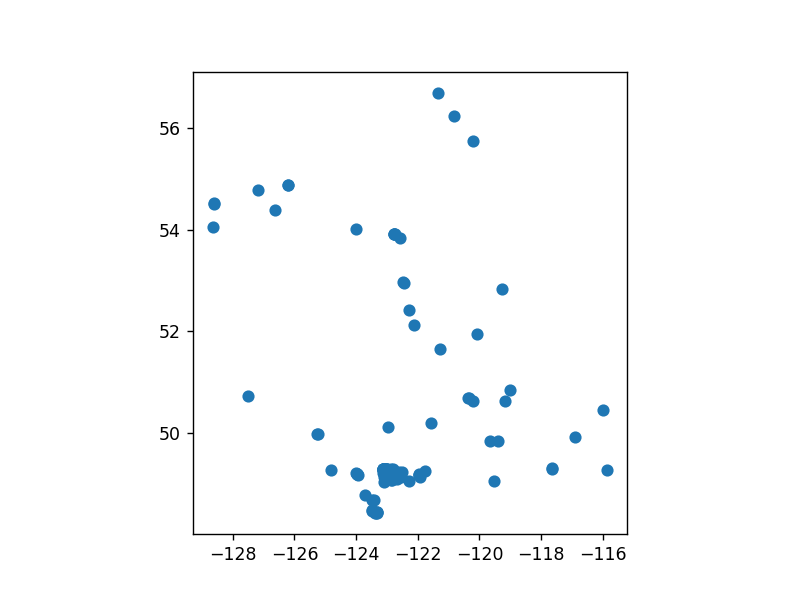

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [116]:
PID_BC = PID_Table.loc[PID_Table['prov']=='BC']
PID_BC = gpd.GeoDataFrame(
                    PID_BC,
                    geometry=gpd.points_from_xy(PID_BC.longitude, PID_BC.latitude),
                    crs='WGS1984'
                        )

PID_BC.plot()
PID_BC.crs

## Read the Census Data, Re-project the points

To GeoJSON data, we just need to specify the driver.

<IPython.core.display.Javascript object>


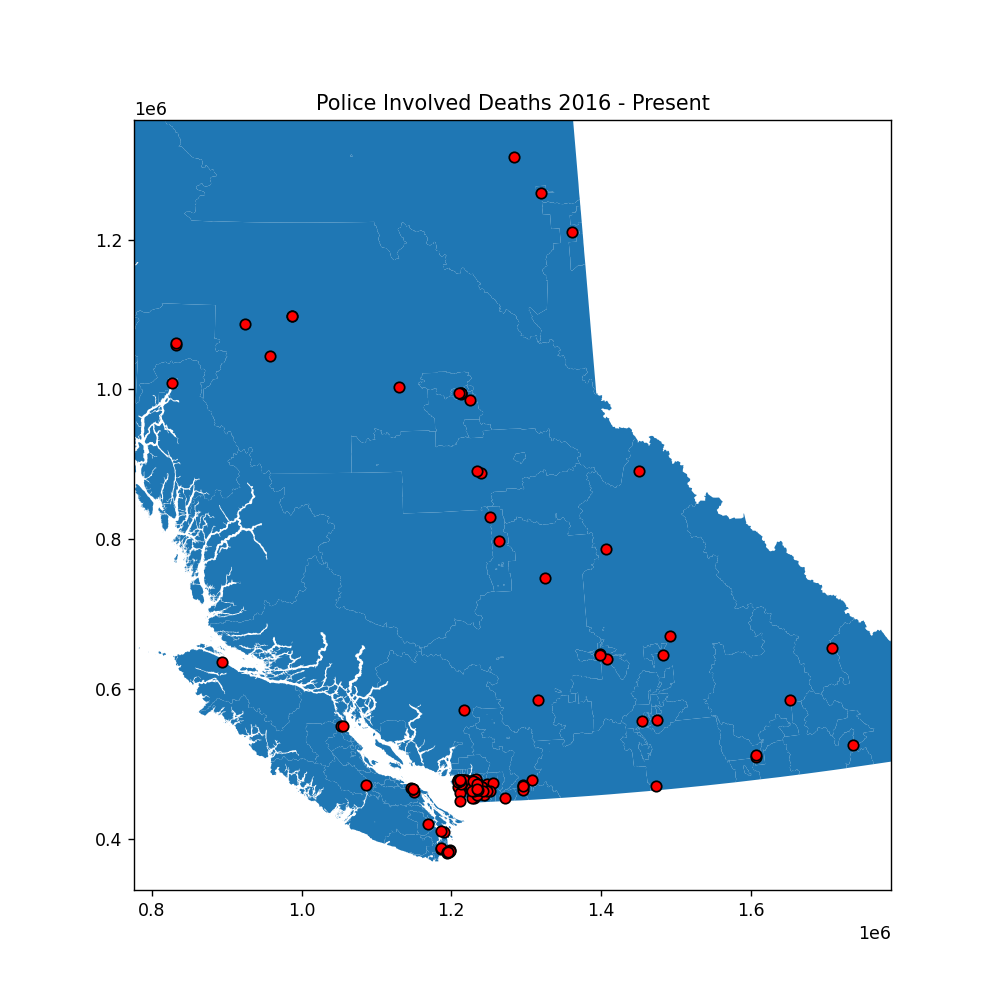

Text(0.5, 1.0, 'Police Involved Deaths 2016 - Present')

In [117]:
BC_FSA = gpd.read_file("data/Outputs/BC_FSA.json", driver = "GeoJSON")

BC_FSA.crs

PID_BC = PID_BC.to_crs(BC_FSA.crs)

fig,ax=plt.subplots(figsize=(8,8))
BC_FSA.plot(ax=ax)
PID_BC.plot(ax=ax,color='r',edgecolor='k')


ax.set_ylim(PID_BC.geometry.y.min()-5e4,PID_BC.geometry.y.max()+5e4)
ax.set_xlim(PID_BC.geometry.x.min()-5e4,PID_BC.geometry.x.max()+5e4)
ax.set_title('Police Involved Deaths 2016 - Present')

# Vector Overlay


Lets import a points layer for some locations in BC and walk through a handful of vector overlay methods.


## Spatial Joins

We can use a [spatial join](https://geopandas.org/gallery/spatial_joins.html) to merge attributes between two layers based on location

<IPython.core.display.Javascript object>


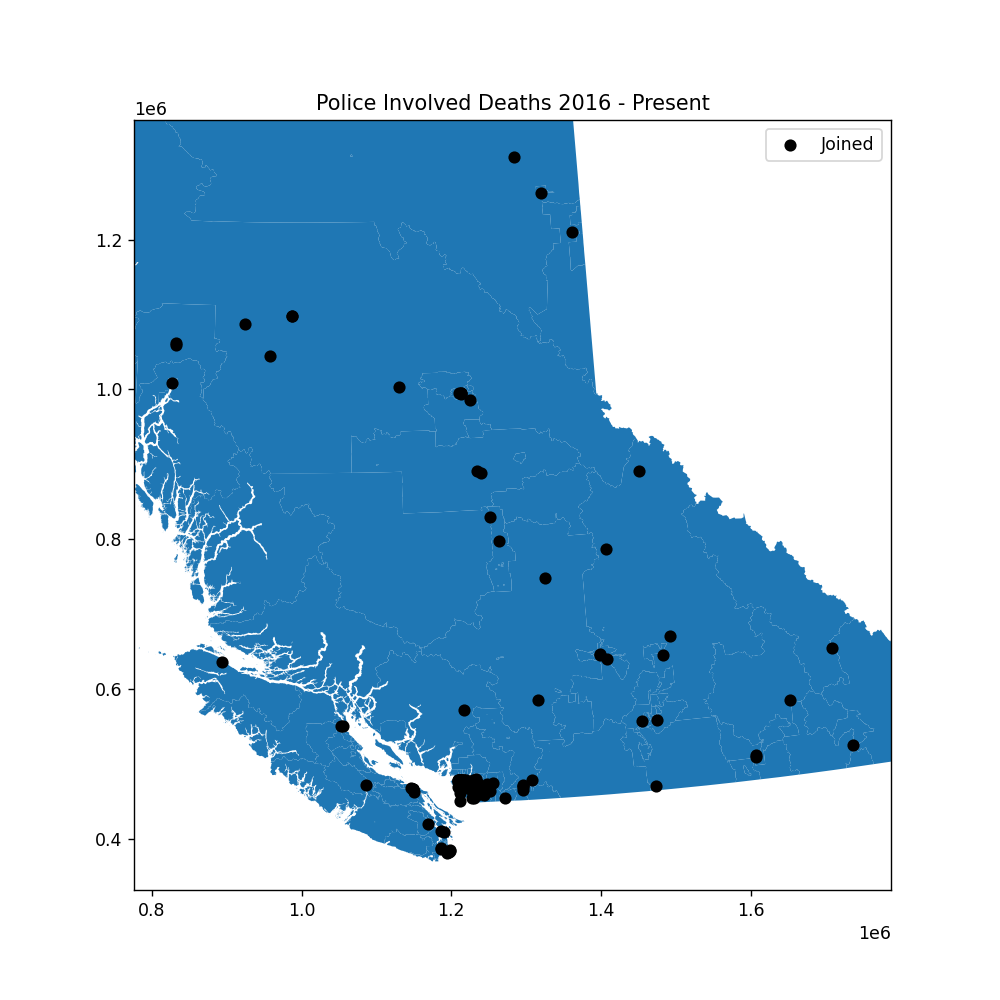

Not Joined:  0


C:\Users\User\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


,date,INDEX,id_victim,first_name,last_name,middle_name,age,gender,race,prov,...,geocoding_return,geocoding_notes,geocode_city,geometry,index_right,spatial_id,name_right,Population,Pop_Density,Community_Type
6,2000-08-21,250,0267_V1,Mladen,Cujko,NaN,33.0,Male,Not Specified,BC,...,"Trans-Canada Highway, Langford, British Columb...",Passed,Langford,POINT (1186026.784 385909.302),170,V9B,"V9B, BC (FSA)",52059.0,713.350309,Urban
18,2002-05-12,303,0266_V1,Paulsey,Alphonse,NaN,67.0,Male,Indigenous,BC,...,"730 Oliver Street, Williams Lake, British Colu...",Passed,Williams Lake,POINT (1263993.164 798105.663),42,V2G,"V2G, BC (FSA)",20475.0,7.708653,Rural
21,2002-08-01,309,0269_V1,Jeffrey,Berg,Michael,37.0,Male,White,BC,...,"The Slocan, 2715 E Hastings St, Vancouver, Bri...",Passed,Vancouver,POINT (1214836.103 478356.167),101,V5K,"V5K, BC (FSA)",24727.0,4203.602210,Urban
24,2002-09-27,317,0479_V1,Darrell,Paquette,Raymond,43.0,Male,Not Specified,BC,...,"1600 15th Avenue, Prince George, British Colum...",Passed,Prince George,POINT (1212359.605 994424.810),46,V2L,"V2L, BC (FSA)",10944.0,1324.617569,Urban
27,2003-07-14,339,0277_V1,Keyvan,Tabesh,NaN,18.0,Male,White,BC,...,"St George Street, Port Moody, British Columbia...",Passed,Port Moody,POINT (1228987.306 478354.911),63,V3H,"V3H, BC (FSA)",44450.0,716.916491,Urban


In [118]:
fig,ax=plt.subplots(figsize=(8,8))

# Changin how to "right" will significantly increase the runtime
# and duplicate each province multiple times (once for each incident within it)
Test_Join = gpd.sjoin(PID_BC, BC_FSA, how="left") 


BC_FSA.plot(ax=ax)
## See if there are any locations "outside" the provincial boundaries
Test_Join.loc[Test_Join['name_right'].isnull()==False].plot(ax=ax,color='k',label='Joined')
Test_Join.loc[Test_Join['name_right'].isnull()].plot(ax=ax,color='r',label='Not Joined')

ax.legend()

Out = Test_Join.loc[Test_Join['name_right'].isnull()]

ax.set_ylim(PID_BC.geometry.y.min()-5e4,PID_BC.geometry.y.max()+5e4)
ax.set_xlim(PID_BC.geometry.x.min()-5e4,PID_BC.geometry.x.max()+5e4)
ax.set_title('Police Involved Deaths 2016 - Present')

print('Not Joined: ',Test_Join.loc[Test_Join['name_right'].isnull()].count()['INDEX'])

Test_Join.head()

## Point In Polygon Analysis

The spatial join method is useful in some cases, but for others, it produces a lot of redundancy.  If your goal is to calculate the number of points per polygon, we can do a point in polygon analysis using the [.within()](https://geopandas.org/docs/reference/api/geopandas.GeoSeries.within.html#geopandas.GeoSeries.within) method. 

In [119]:
BC_FSA['Deaths'] = 0.0
for i,row in BC_FSA.iterrows():
#     print(i)
    pip = PID_BC.within(row['geometry'])
#     print(pip)
    if pip.sum()>0:
        BC_FSA.loc[BC_FSA.index==i,'Deaths']+=pip.sum()
print(BC_FSA['Deaths'].describe())

count    189.000000
mean       0.671958
std        1.035696
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        7.000000
Name: Deaths, dtype: float64


In [120]:
BC_FSA['Population'].describe()

BC_FSA['Mask']=0
BC_FSA.loc[BC_FSA['Population']*.2<30,'Mask']=1

print(BC_FSA.groupby('Mask').count())

      spatial_id  name  Population  Pop_Density  Community_Type  geometry  \
Mask                                                                        
0            189   189         189          189             189       189   

      Deaths  
Mask          
0        189  


<IPython.core.display.Javascript object>


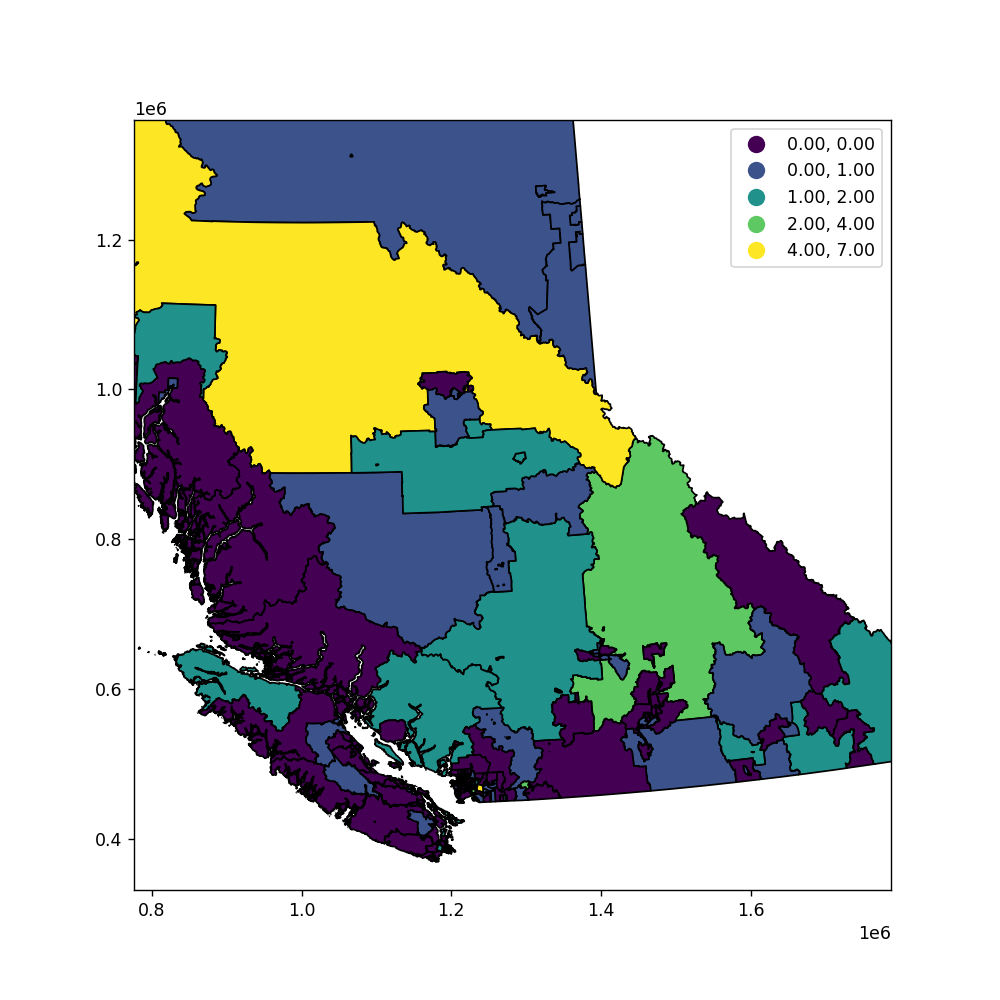

(776693.5463433585, 1786914.951293358)

In [121]:
fig,ax=plt.subplots(figsize=(8,8))
BC_FSA.plot(column='Deaths',ax=ax,legend=True,scheme="User_Defined", 
         classification_kwds=dict(bins=[0,1,2,4,
             BC_FSA['Deaths'].max()]),
                    edgecolor='k')


ax.set_ylim(PID_BC.geometry.y.min()-5e4,PID_BC.geometry.y.max()+5e4)
ax.set_xlim(PID_BC.geometry.x.min()-5e4,PID_BC.geometry.x.max()+5e4)

# BC_FSA_Clip.to_file('data/BC_FSAisions.shp')

# Calculating the Death Rate

<IPython.core.display.Javascript object>


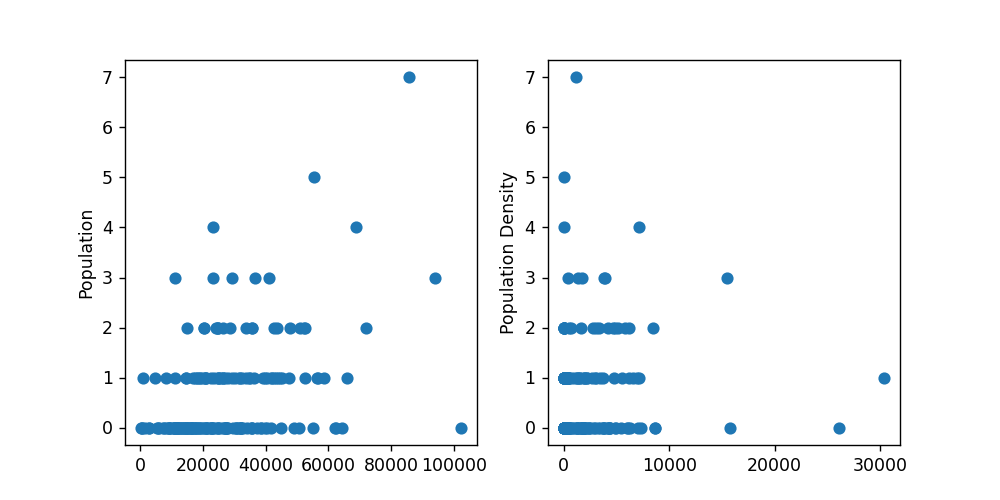

Text(0, 0.5, 'Population Density')

In [122]:
fig,ax=plt.subplots(1,2,figsize = (8,4))
ax[0].scatter(BC_FSA['Population'],BC_FSA['Deaths'])
ax[0].set_ylabel('Deaths')
ax[0].set_ylabel('Population')


ax[1].scatter(BC_FSA['Pop_Density'],BC_FSA['Deaths'])
ax[1].set_ylabel('Deaths')
ax[1].set_ylabel('Population Density')



<IPython.core.display.Javascript object>


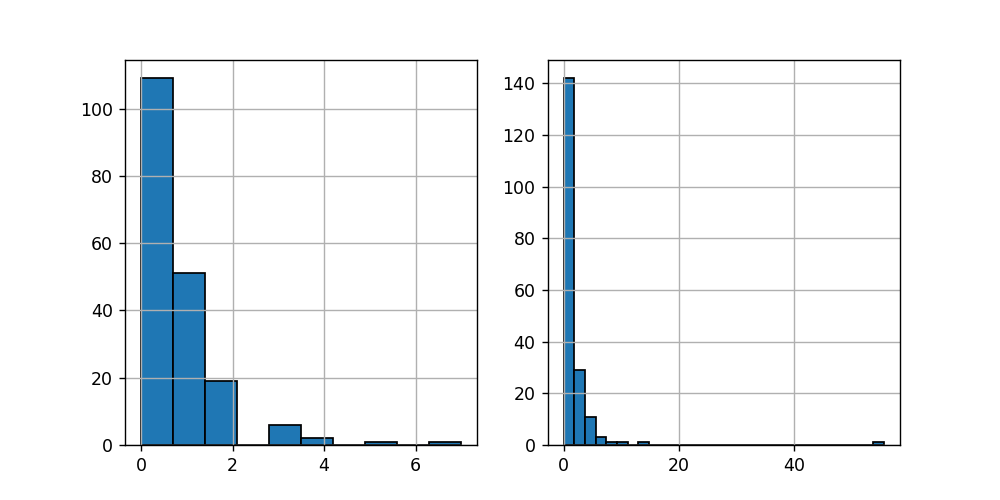

<AxesSubplot:>

In [123]:
BC_FSA['Death_Rate']=BC_FSA['Deaths']/BC_FSA['Population']*1e6/21
BC_FSA['Death_Rate']=BC_FSA['Death_Rate'].fillna(0)

fig,ax=plt.subplots(1,2,figsize=(8,4))
BC_FSA['Deaths'].hist(ax=ax[0],edgecolor='k')
BC_FSA['Death_Rate'].hist(ax=ax[1],bins=30,edgecolor='k')

In [134]:
print(BC_FSA.loc[BC_FSA['Death_Rate']==BC_FSA['Death_Rate'].max()])



    spatial_id           name  Population  Pop_Density Community_Type  \
135        V7B  V7B, BC (FSA)       857.0    36.773975          Rural   

                                              geometry  Deaths  Mask  \
135  MULTIPOLYGON (((1199364.487 475238.869, 119924...     1.0     0   

     Death_Rate  
135   55.564816  


<IPython.core.display.Javascript object>


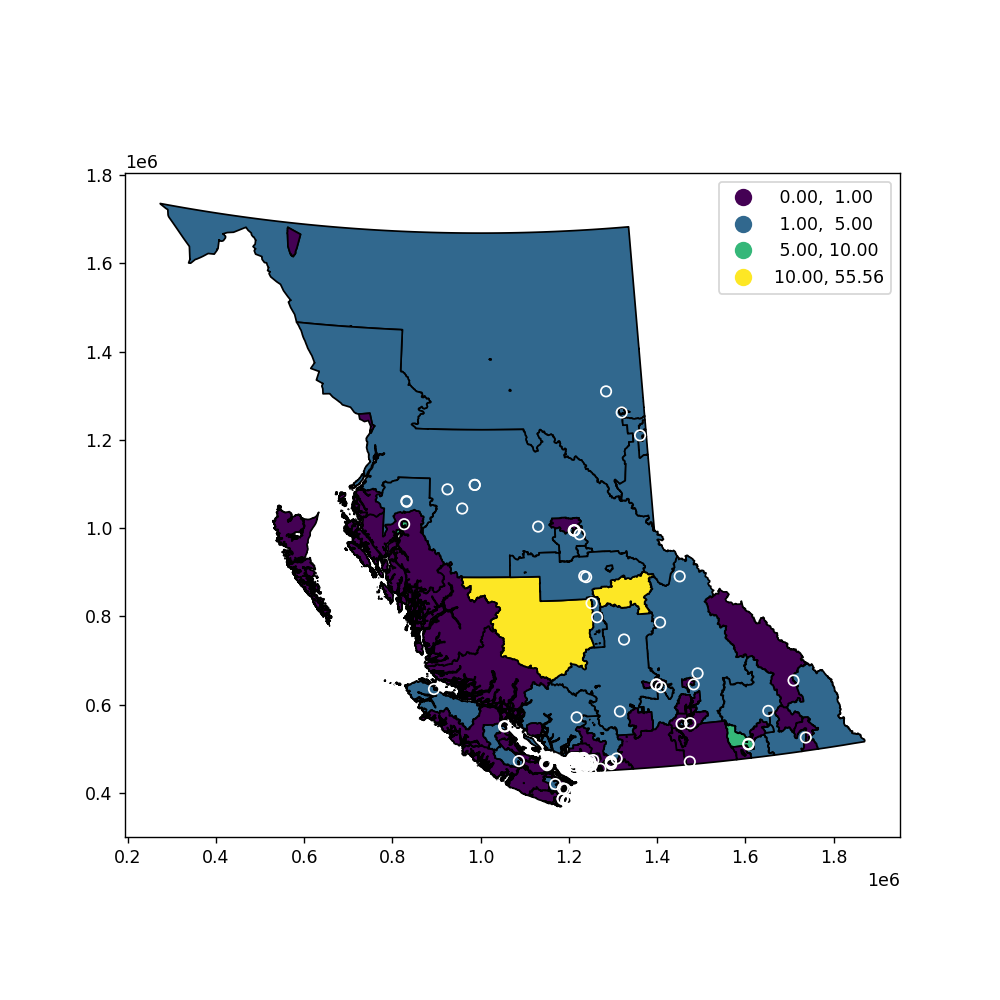

<IPython.core.display.Javascript object>


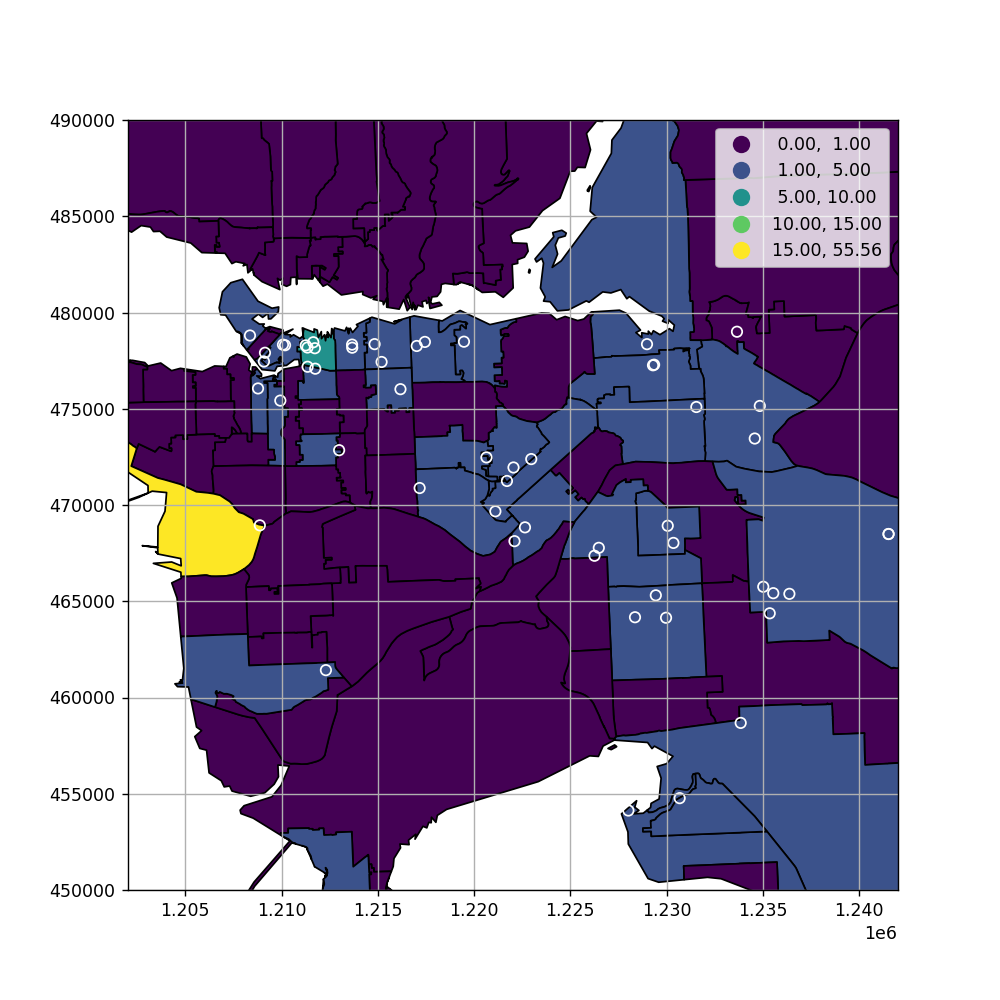

In [133]:


fig,ax=plt.subplots(figsize=(8,8))
BC_FSA.plot(column='Death_Rate',ax=ax,legend=True,scheme="User_Defined", 
         classification_kwds=dict(bins=[1,5,10,
             BC_FSA['Death_Rate'].max()]),
                    edgecolor='k')

PID_BC.plot(ax=ax,facecolor='None'
            ,edgecolor='white')





fig,ax=plt.subplots(figsize=(8,8))
BC_FSA.plot(column='Death_Rate',ax=ax,legend=True,scheme="User_Defined", 
         classification_kwds=dict(bins=[1,5,10,
                                             BC_FSA['Death_Rate'].max()]),
                    edgecolor='k')

PID_BC.plot(ax=ax,facecolor='None'
            ,edgecolor='white')

# ## Set Zoom & Turn Grid off
x = 1.222e6
y = 0.47e6

Size = 4e4
v = Size/2
h = Size/2



ax.set_xlim(x-h,x+h)
ax.set_ylim(y-h,y+h)
ax.grid()


## Kernel Density

0.0 0.00023929179340151905 2.85810709267774e-07 0.9691212367709827


<IPython.core.display.Javascript object>


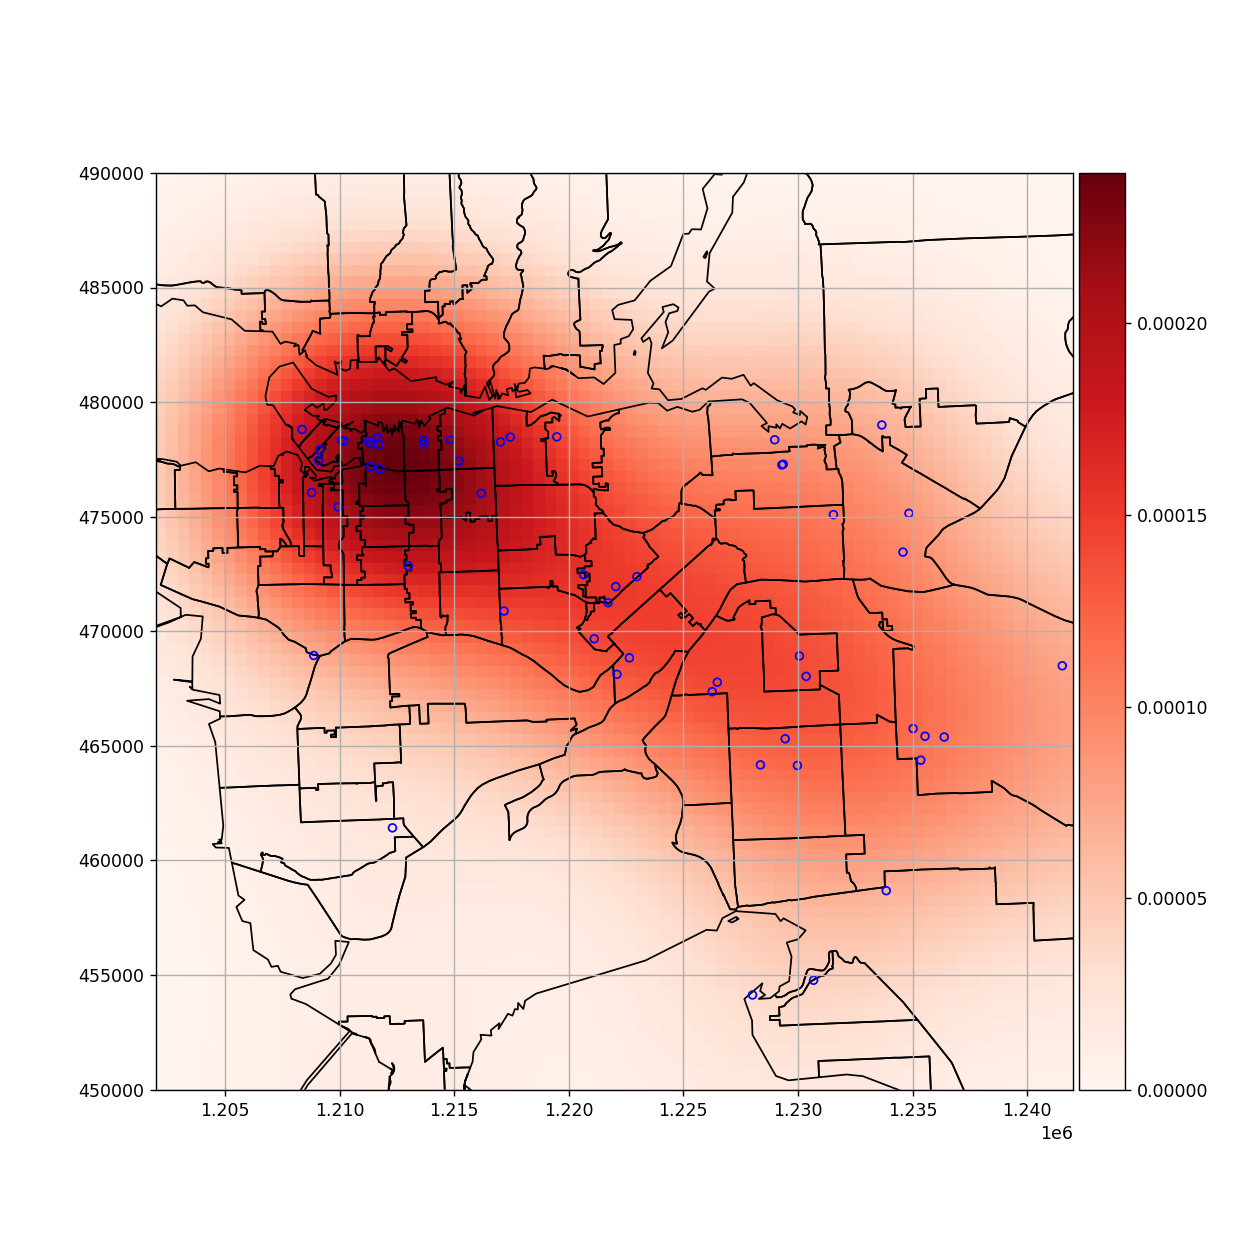

In [127]:
from sklearn.neighbors import KernelDensity
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio
from rasterio.plot import show

def kde2D(x, y, bandwidth, cell_size=1e3, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    # Transform ipnut points to x,y pairs
    xy_train  = np.vstack([y, x]).T
    # Fit the kernel density model
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    """Construct the Output Image"""
    # Our "Null" hypothesis is a uniform 2D distribution - create a 2D grid
    # Subtract/Add the cell size to the min/max the intervals are fully inclusive of the feature space
    x_ax = np.arange(x.min()-cell_size,x.max()+cell_size,cell_size)
    y_ax = np.arange(y.min()-cell_size,y.max()+cell_size,cell_size)
    xx, yy = np.meshgrid(x_ax,y_ax)
    
    # Transform the grid points to x,y pairs
    xy_test = (np.vstack([yy.ravel(), xx.ravel()]).T)
    
    # score_samples() returns the log-likelihood of the samples
    # convert units to the cell size (z will ~ sum to 1 after conversion)
    z = np.exp(kde_skl.score_samples(xy_test))*cell_size**2
    return xx, yy, np.reshape(z, xx.shape)


x = PID_BC.geometry.x.values
y = PID_BC.geometry.y.values

xx, yy, zz = kde2D(x, y,
                   5000,# 5km band width
                   cell_size=500, #1km cell size
                   kernel='gaussian')

print(zz.min(),zz.max(),zz.mean(),(zz).sum())

fig,ax=plt.subplots(figsize=(10,10))

cb = ax.pcolormesh(xx, yy, zz,shading='auto',cmap='Reds')

BC_FSA.plot(ax=ax,facecolor='None',edgecolor='k')
ax.scatter(G.geometry.x, G.geometry.y, s=20,edgecolor='b', facecolor='None')#,legend=True)
# ax.legend()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(cb, cax=cax)


# ## Set Zoom & Turn Grid off
x = 1.222e6
y = 0.47e6

Size = 4e4
v = Size/2
h = Size/2

ax.set_xlim(x-h,x+h)
ax.set_ylim(y-h,y+h)
ax.grid()

# Save A Raster Image

* We can use Rasterio write a raster layer

826193.5463433585 380747.4026558375 1737193.5463433585 1310247.4026558376
| 489.78, 0.00, 826193.55|
| 0.00,-509.87, 1310247.40|
| 0.00, 0.00, 1.00|


<IPython.core.display.Javascript object>


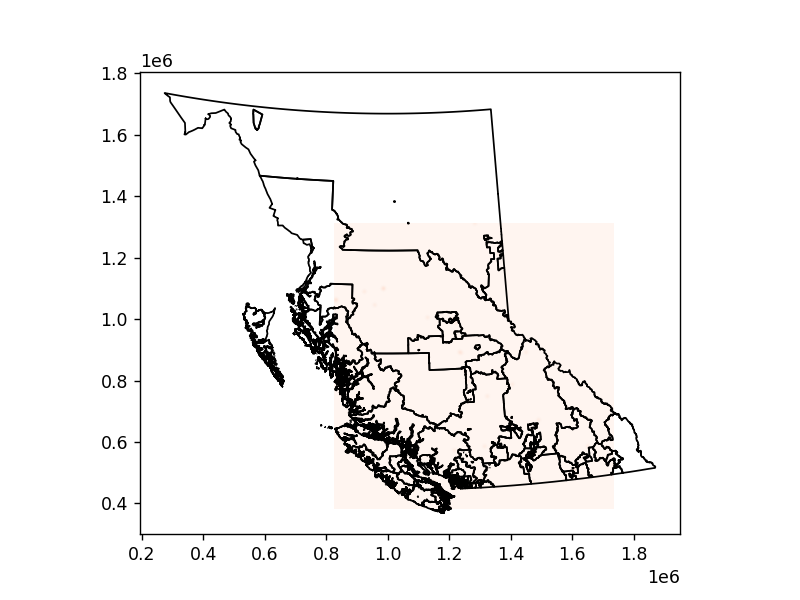

In [129]:

import rasterio as rio
trans = rio.transform.from_bounds(xx.min(), yy.min(), xx.max(), yy.max(), int(xx.shape[0]), int(yy.shape[1]))

print(xx.min(), yy.min(), xx.max(), yy.max())
print(trans)

with rio.open('Kernel_Density.tif', 'w',
                  dtype=rio.float32,
                  count=1,
                  compress='lzw',
                  width=int(xx.shape[0]),
                  height=int(yy.shape[1]),
                  transform=trans) as dst:
    dst.write(np.flip(zz,axis=0).astype(rio.float32), 1)
print('Saved')

# Plot the Raster

<IPython.core.display.Javascript object>


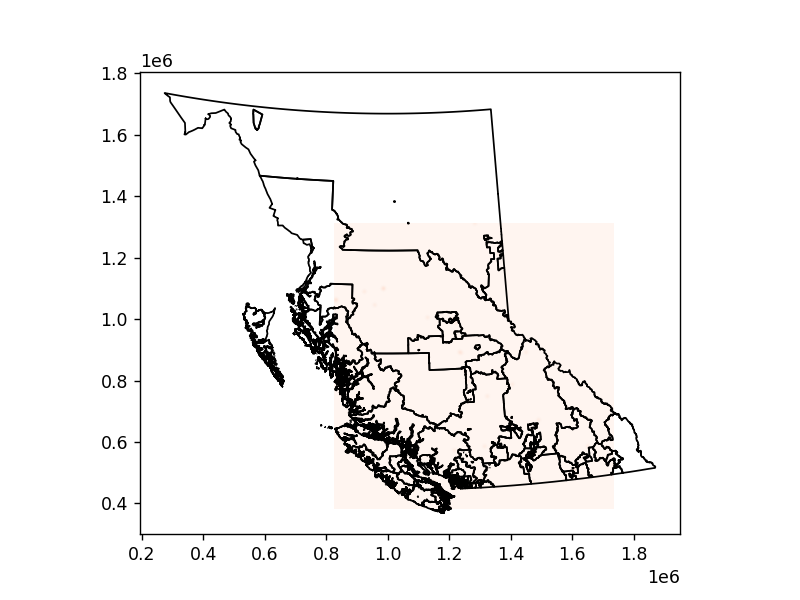

In [131]:

from rasterio.plot import show
fig,ax=plt.subplots()
with rio.open('Kernel_Density.tif','r') as Test:
    show(Test,ax=ax,cmap='Reds')
    
BC_FSA.plot(ax=ax,facecolor='None',edgecolor='k')
    
    
# ## Set Zoom & Turn Grid off
x = 1.222e6
y = 0.47e6

Size = 4e4
v = Size/2
h = Size/2